# DBSCAN grid search for epsilon and min samples parameters - Lower Epsilon

After running nearest neighbors on a subset of our data, we initially narrow down optimal epsilon to between 0.8-0.9

To make a grid search feasable time wise, we first loaded a subset of our dataset for grid search: 1500 squad2 examples - the first 300 from each file output from our pipeline starting from 10.000,30.000,50.000,70.000,90.000

Subsequent grid searches were performed on half of the 300 example subset, 3900 examples - skipping 10,000 examples at a time - i.e. 5000,15000, ... 125000

Output is visualized in dbscan_cluster_analysis.ipynb

In [1]:
import os
import time

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
from cuml.cluster import KMeans as cuKMeans
from cuml.neighbors import NearestNeighbors
import cupy

In [4]:
from dask_cuda import LocalCUDACluster
import dask_cudf
from dask.distributed import Client
import dask.dataframe as dd
from cuml.dask.cluster.dbscan import DBSCAN as daskDBSCAN

In [5]:
import torch

In [6]:
output_dir='/rapids/notebooks/host/representations/output/low_epsilon/'

In [7]:
# cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0,1")
# client = Client(cluster)

In [8]:
client = Client("tcp://127.0.0.1:42369")
client

Client Scheduler: tcp://127.0.0.1:42369 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 125.50 GiB


In [9]:
import glob

def pd_read_pattern(pattern):
    files = glob.glob(pattern)

    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f))

    return df.reset_index(drop=True)

def layer(index):
    layer_head_location = index % 144
    return int(layer_head_location/12)
    
def head(index):
    layer_head_location = index % 144
    layer = int(layer_head_location/12)
    return layer_head_location % 12

def index_layer_heads(df):
    df.rename(columns={0:'cluster'},inplace=True)
    df['layer'] = (df.index.to_series().apply(layer))
    df['head'] = (df.index.to_series().apply(head))
    return df

In [12]:
# load full partitioned dataset - read in as pandas df,
# for some reason dask cuml dbscan doesn't accept a dask cdDF?
# https://docs.rapids.ai/api/cuml/nightly/api.html?highlight=regression#multi-node-multi-gpu-algorithms
gdf = pd_read_pattern('/rapids/notebooks/host/representations/final/partitions_2/tuning_set/*.csv')

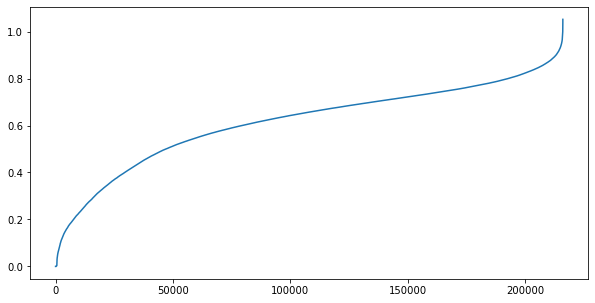

In [20]:
# %matplotlib widget
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=5).fit(gdf)
distances, idx = nn.kneighbors(gdf)
distances = cupy.asnumpy(distances)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# plt.xticks(np.arange(min(distances), max(distances)+1, 1.0))
plt.plot(distances)

In [13]:

results = pd.DataFrame(columns=['eps','min_samples','n_clusters','n_noise'])

epsilon_range = np.linspace(0.30,0.80,4)
min_sample_range = [10]
# min_sample_range = range(4,30,6)

for e in epsilon_range:
    for m in min_sample_range:
        eps = e
        min_samples = m
        cuml_dbscan = daskDBSCAN( eps = eps,
                                  metric='euclidean',
                                  min_samples = min_samples,
                                  max_mbytes_per_batch = 10000
                                )

        trained_DBSCAN = cuml_dbscan.fit(gdf)
        labels = trained_DBSCAN.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        print(f'e: {eps} s: {min_samples} c: {n_clusters_} n: {n_noise_}')
        
        df_labels = pd.DataFrame(labels)
        df_labels = index_layer_heads(df_labels)

        torch.save(df_labels, os.path.join(output_dir,f'dask_dbscan_{eps}_{min_samples}_label_df.bin'))

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters_,
            'n_noise': n_noise_
        }, ignore_index=True)

torch.save(results, os.path.join(output_dir,'results_df.bin'))

e: 0.3 s: 10 c: 0 n: 216000
e: 0.4666666666666667 s: 10 c: 17 n: 213260
e: 0.6333333333333333 s: 10 c: 27 n: 174224
e: 0.8 s: 10 c: 43 n: 40278


In [14]:

results = pd.DataFrame(columns=['eps','min_samples','n_clusters','n_noise'])

epsilon_range = np.arange(0.10,0.30,0.1)
min_sample_range = [10]


for e in epsilon_range:
    for m in min_sample_range:
        eps = e
        min_samples = m
        cuml_dbscan = daskDBSCAN( eps = eps,
                                  metric='euclidean',
                                  min_samples = min_samples,
                                  max_mbytes_per_batch = 10000
                                )

        trained_DBSCAN = cuml_dbscan.fit(gdf)
        labels = trained_DBSCAN.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        print(f'e: {eps} s: {min_samples} c: {n_clusters_} n: {n_noise_}')
        
        df_labels = pd.DataFrame(labels)
        df_labels = index_layer_heads(df_labels)

        torch.save(df_labels, os.path.join(output_dir,f'dask_dbscan_{eps}_{min_samples}_label_df.bin'))

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters_,
            'n_noise': n_noise_
        }, ignore_index=True)

torch.save(results, os.path.join(output_dir,'results_0.1-0.3_df.bin'))

e: 0.1 s: 10 c: 0 n: 216000
e: 0.2 s: 10 c: 0 n: 216000


In [11]:
# load full partitioned dataset - read in as pandas df,
# for some reason dask cuml dbscan doesn't accept a dask cdDF?
# https://docs.rapids.ai/api/cuml/nightly/api.html?highlight=regression#multi-node-multi-gpu-algorithms
gdf = pd_read_pattern('/rapids/notebooks/host/representations/final/partitions/half/*.csv')
# loading  0-125,000 skipping 10,000 at a time - 300 examples per file

In [12]:

results = pd.DataFrame(columns=['eps','min_samples','n_clusters','n_noise'])

epsilon_range = np.arange(0.60,0.80,0.1)

for e in epsilon_range:
    eps = e
    min_samples = 10
    cuml_dbscan = daskDBSCAN( eps = eps,
                              metric='euclidean',
                              min_samples = min_samples,
                              max_mbytes_per_batch = 10000
                            )
    print(f'Fitting e: {eps} s: {min_samples}')
    trained_DBSCAN = cuml_dbscan.fit(gdf)
    labels = trained_DBSCAN.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print(f'e: {eps} s: {min_samples} c: {n_clusters_} n: {n_noise_}')

    df_labels = pd.DataFrame(labels)
    df_labels = index_layer_heads(df_labels)

    torch.save(df_labels, os.path.join(output_dir,f'dask_dbscan_{eps}_{min_samples}_label_df.bin'))

    results.append({
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters_,
        'n_noise': n_noise_
    }, ignore_index=True)

torch.save(results, os.path.join(output_dir,'results_0.5-0.7_df.bin'))

Fitting e: 0.6 s: 10
e: 0.6 s: 10 c: 645 n: 476443
Fitting e: 0.7 s: 10
e: 0.7 s: 10 c: 282 n: 296926
Fitting e: 0.7999999999999999 s: 10


CancelledError: 

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
